## Variable Selection for Classifier that Predicts Death of Heart Failure Patients


## Introduction

Heart failure occurs when the damaged or weakened heart muscle is unbale to pump blood efficiently to meet body’s needs. Multiple researches found that the risk factors of heart failure include but not limited to high blood pressure, diabetes, and smoking (Inamdar & Inamdar, 2016). This leads to the question of which predictor(s) are useful in predicting a heart failure patient’s survival after some period of time given their information. To answer this question, we will build models to analyze the “Heart Failure Prediction” dataset that was collected by Ahmad et al. in 2017. There are 11 predictors in the dataset but only 10 will be used:

* Age (years)
* Anaemia status (binary)
* Blood creatinine phosphokinase level (mcg/L) 
* Diabetes status (binary)
* Ejection fraction (percentage of blood leaving the heart at each contraction)
* High blood pressure status (binary)
* Platelets level in blood (kiloplatelets/mL)
* Level of serum creatinine in blood (mg/dL)
* Level of serum sodium in blood (mEq/L)
* Sex (binary, 0 for female and 1 for male)
* Smoking status (binary)

## Preliminary Exploratory Data Analysis

In [3]:
# import libraries for R functions

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [4]:
# load data from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
original_data <- read_csv(url)
# original_data

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# turn binary variables into factors

original_data <- original_data |>
    mutate(anaemia = as_factor(anaemia),
          diabetes = as_factor(diabetes),
          high_blood_pressure = as_factor(high_blood_pressure),
          platelets_num_per_mL = platelets/1000,
          sex = as_factor(sex),
          smoking = as_factor(smoking),
          DEATH_EVENT = as_factor(DEATH_EVENT))

# man is 1 in sex, woman is 0 since the paper said 194 men and 105 women, filtering for sex == 1 gives as 194 rows

In [31]:
# split the data into training and testing sets

set.seed(1625)

# split the data for 75% training and 25% testing, roughly same ratio of survived to dead in both sets as the original
data_split <- initial_split(original_data, prop = 0.75, strata = DEATH_EVENT)
training_data <- training(data_split)

In [7]:
# finding summary data of the training set

# mean of numerical predictors among survived or dead patients

numerical_preds <- c("Age (years)", "Creatinine phosphokinase (mcg/L)", "Ejection fraction (%)", "Platelet level (platelet/mL)", 
                     "Serum creatinine (mg/dL)", "Serum sodium (mEq/L)", "Follow-up period length (days)")

# make a function to find the mean of the numerical predictors among the survived patients
find_mean_survived <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 0)$Predictor, na.rm = TRUE)
        #mean_summary_dead[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}


# make a function to find the mean of the numerical predictors among the dead patients
find_mean_dead <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}

# find the mean for each numerical predictors among the survived patients
mean_summary_survived <- find_mean_survived(training_data)

# find the mean for each numerical predictors among the dead patients
mean_summary_dead <- find_mean_dead(training_data)



# make a function to find the percentage of survived patients for each category of categorial variables

categorical_preds <- c("Anaemia", "No anameia", "Diabetes", "No diabetes", "High blood pressure", 
                       "No high blood pressure", "Male", "Female", "Smoker", "Non-smoker")


find_ratio_yes <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_yes <- filter(grouped_columns, Predictor == 1)[,2]

        number_survived_yes <- nrow(filter(filtered_response_yes, Response == 0))
        
        result_list[i] <- number_survived_yes/nrow(filtered_response_yes)*100
        
    }
    
    result_list
        
}



find_ratio_no <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_no <- filter(grouped_columns, Predictor == 0)[,2]

        number_survived_no <- nrow(filter(filtered_response_no, Response == 0))
        
        result_list[i] <- number_survived_no/nrow(filtered_response_no)*100
        
    }
    
    result_list
        
}

ratio_summary_yes <- find_ratio_yes(training_data)

ratio_summary_no <- find_ratio_no(training_data)

ratio_summary <- c(ratio_summary_yes[1], ratio_summary_no[1],
                   ratio_summary_yes[2], ratio_summary_no[2],
                   ratio_summary_yes[3], ratio_summary_no[3],
                   ratio_summary_yes[4], ratio_summary_no[4],
                   ratio_summary_yes[5], ratio_summary_no[5])


##### Summary Table 1. Mean of numerical predictors across survived and dead patients

In [8]:
# Create summary table 1
options(repr.matrix.max.rows = 10)
table_1 <- tibble(numerical_preds, round(mean_summary_survived, 4), round(mean_summary_dead, 4))
colnames(table_1) <- c("Predictor", "Mean predictor value among survived patients", "Mean predictor value among dead patients")
head(table_1, n = 10)

Predictor                        Mean predictor value among survived patients
1 Age (years)                       59.2675                                    
2 Creatinine phosphokinase (mcg/L) 521.2368                                    
3 Ejection fraction (%)             40.4408                                    
4 Platelet level (platelet/mL)     267.9566                                    
5 Serum creatinine (mg/dL)           1.2170                                    
6 Serum sodium (mEq/L)             136.8684                                    
7 Follow-up period length (days)   164.6447                                    
  Mean predictor value among dead patients
1  65.5232                                
2 612.4583                                
3  33.5694                                
4 255.1737                                
5   1.8928                                
6 135.1389                                
7  74.0139

In [9]:
# Create summary table 2
options(repr.matrix.max.rows = 10)
table_2 <- tibble(categorical_preds, round(ratio_summary, 4))
colnames(table_2) <- c("Predictor", "Percentage of survived patients")
head(table_2, 10)

Predictor              Percentage of survived patients
1  Anaemia                62.3656                        
2  No anameia             71.7557                        
3  Diabetes               68.4783                        
4  No diabetes            67.4242                        
5  High blood pressure    61.3333                        
6  No high blood pressure 71.1409                        
7  Male                   69.9301                        
8  Female                 64.1975                        
9  Smoker                 70.8333                        
10 Non-smoker             66.4474

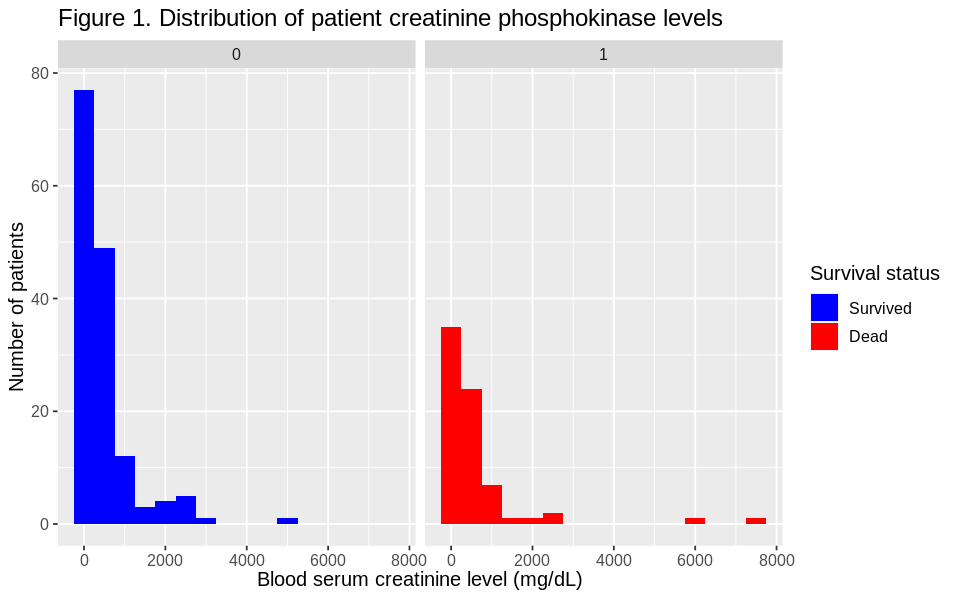

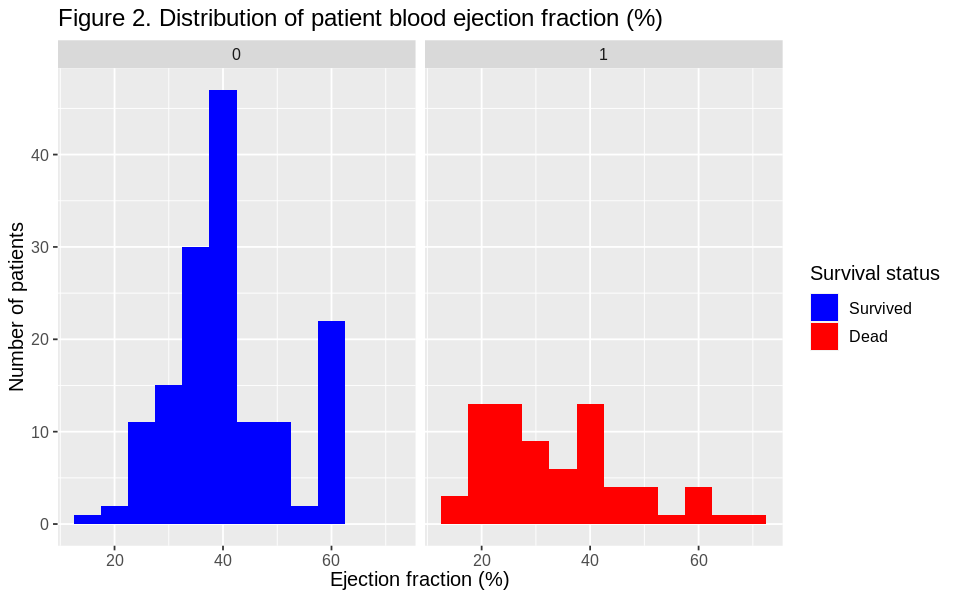

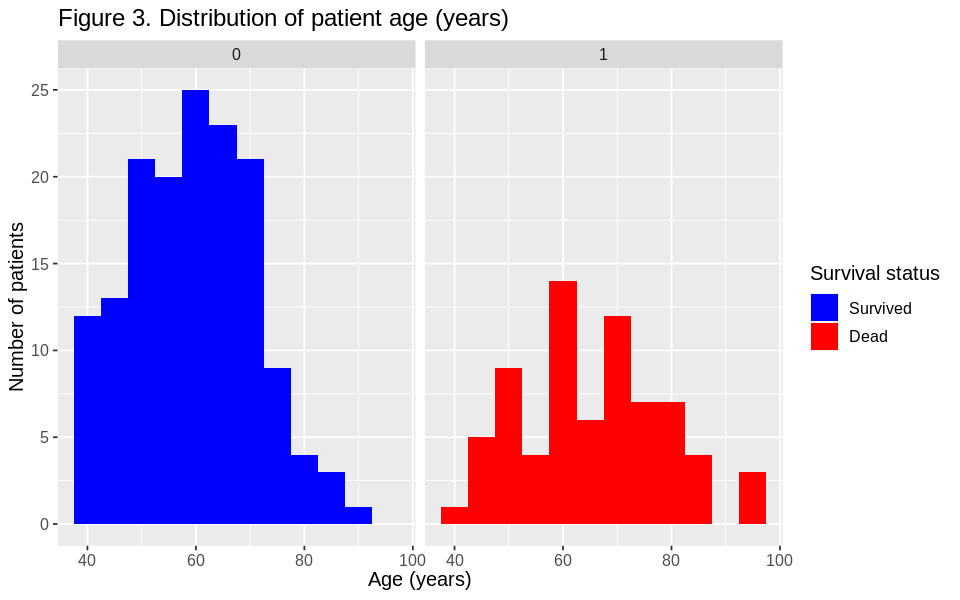

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



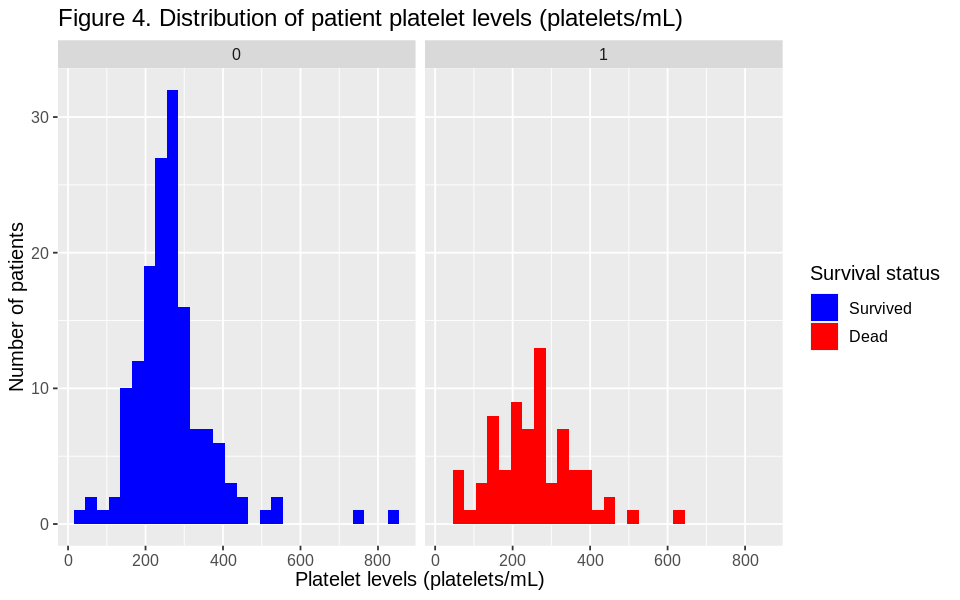

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



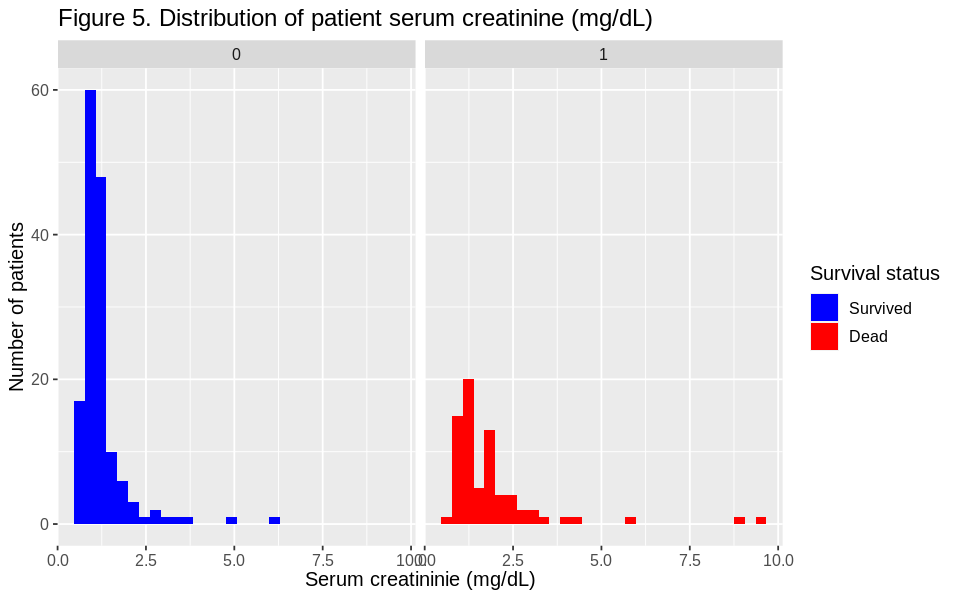

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



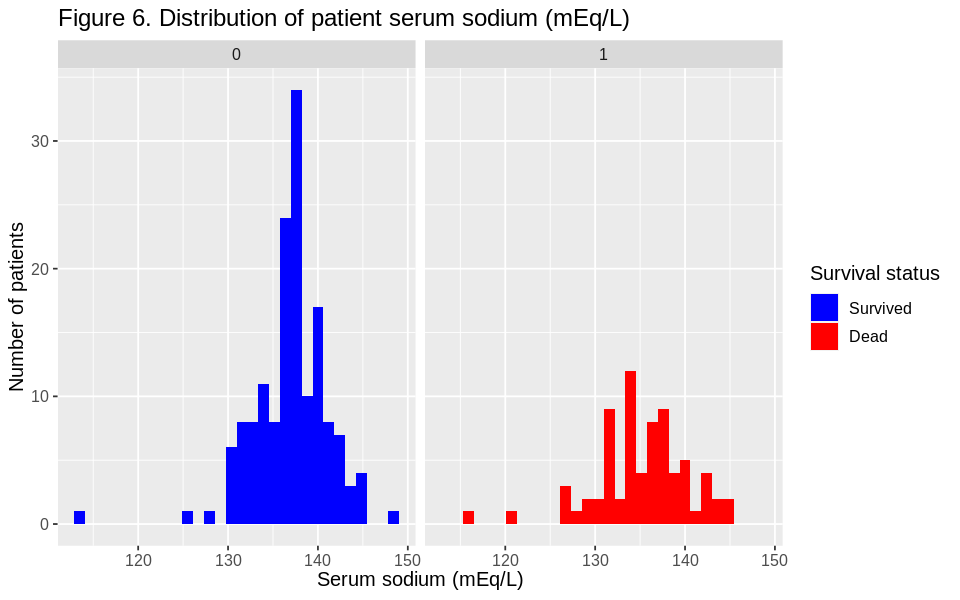

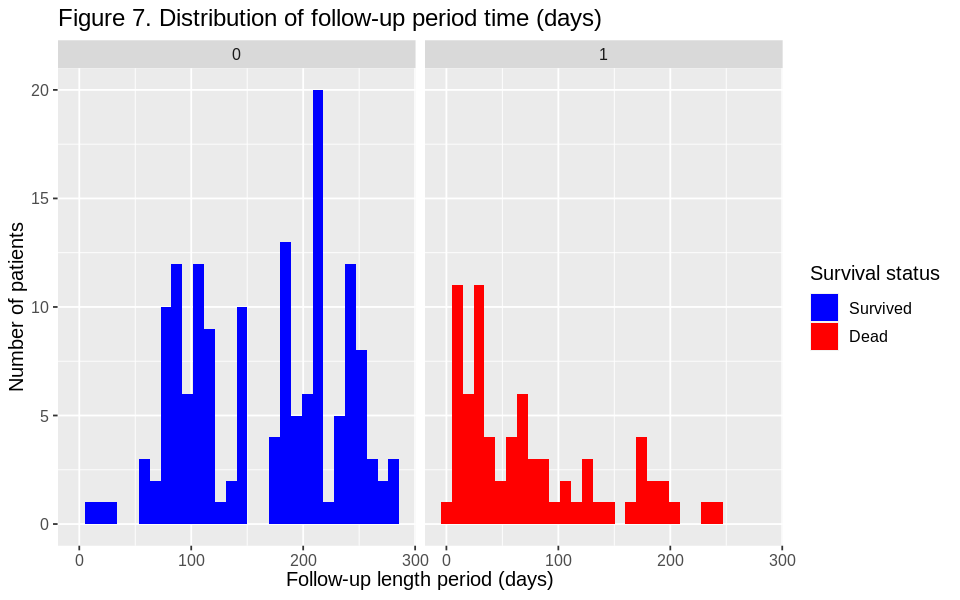

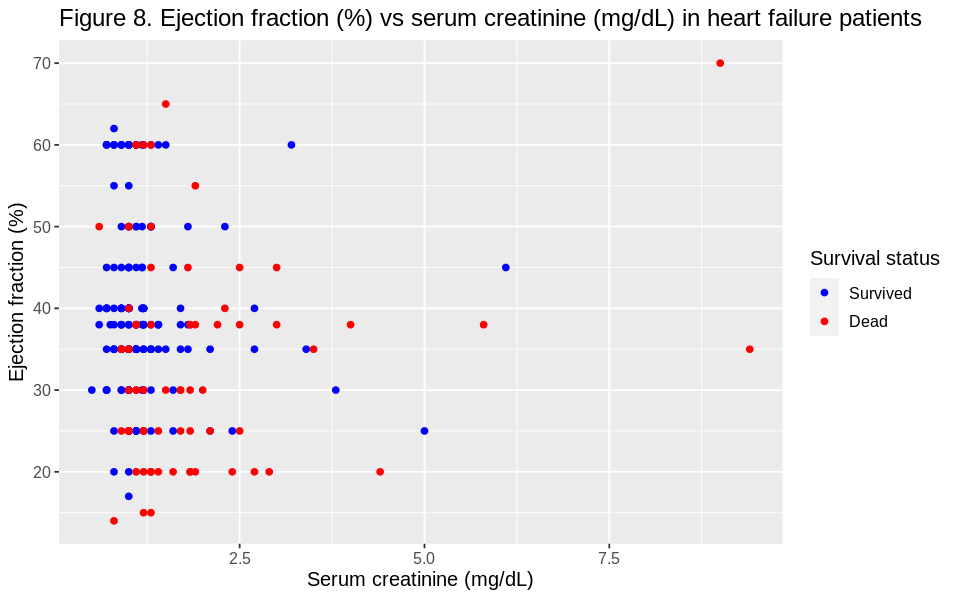

In [10]:
# Plots
options(repr.plot.height = 5, repr.plot.width = 8)

plot1 <- training_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 500) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Blood serum creatinine level (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 1. Distribution of patient creatinine phosphokinase levels") + 
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot1

plot2 <- training_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Ejection fraction (%)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 2. Distribution of patient blood ejection fraction (%)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot2

plot3 <- training_data |>
    ggplot(aes(x = age, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Age (years)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 3. Distribution of patient age (years)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot3

plot4 <- training_data |>
    ggplot(aes(x = platelets_num_per_mL, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 30) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Platelet levels (platelets/mL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 4. Distribution of patient platelet levels (platelets/mL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot4

plot5 <- training_data |>
    ggplot(aes(x = serum_creatinine, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum creatininie (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 5. Distribution of patient serum creatinine (mg/dL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot5

plot6 <- training_data |>
    ggplot(aes(x = serum_sodium, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum sodium (mEq/L)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 6. Distribution of patient serum sodium (mEq/L)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot6

plot7 <- training_data |>
    ggplot(aes(x = time, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Follow-up length period (days)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 7. Distribution of follow-up period time (days)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot7

plot8 <- training_data |>
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT)) +
    geom_point() +
    labs(x = "Serum creatinine (mg/dL)",
         y = "Ejection fraction (%)",
         color = "Survival status",
         title = "Figure 8. Ejection fraction (%) vs serum creatinine (mg/dL) in heart failure patients") +
    scale_color_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot8

### Predictor Variable Selection ###

#### GG Pair Plot ####

In [11]:
colnames(training_data)

[1] "age"                      "anaemia"                 
 [3] "creatinine_phosphokinase" "diabetes"                
 [5] "ejection_fraction"        "high_blood_pressure"     
 [7] "platelets"                "serum_creatinine"        
 [9] "serum_sodium"             "sex"                     
[11] "smoking"                  "time"                    
[13] "DEATH_EVENT"              "platelets_num_per_mL"

#### Forward Variable Selection ####

In [12]:
# code is made based on references to Textbook section 6.8
# set seed for reproducible results
set.seed(2130)

# original order
wotime_train_ver_1 <- training_data |>
    select(age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction, high_blood_pressure, 
           platelets_num_per_mL, serum_creatinine, serum_sodium, sex, smoking, DEATH_EVENT)

# serum_creatinine and ejection_fraction first, other variables in a some-what random order
wotime_train_ver_2 <- training_data |>
    select(serum_creatinine, ejection_fraction, sex, age, creatinine_phosphokinase, anaemia, platelets_num_per_mL,
          smoking, diabetes, high_blood_pressure, serum_sodium, DEATH_EVENT)

# all numeric variables first, then binary variables
wotime_train_ver_3 <- training_data |>
    select(age, creatinine_phosphokinase, platelets_num_per_mL, ejection_fraction, serum_creatinine,
          serum_sodium, anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)

# all binary variables first, then numeric variables
wotime_train_ver_4 <- training_data |>
    select(anaemia, diabetes, high_blood_pressure, sex, smoking, age, creatinine_phosphokinase, platelets_num_per_mL, 
           ejection_fraction, serum_creatinine, serum_sodium, DEATH_EVENT)

# random order
wotime_train_ver_5 <- training_data |>
    select(high_blood_pressure, serum_sodium, anaemia,diabetes, smoking, creatinine_phosphokinase, sex,
           platelets_num_per_mL, ejection_fraction, anaemia, serum_creatinine, age, DEATH_EVENT)


# turn this into a function
do_forward_selection <- function(data_train) {
    
    accuracies <- tibble(size = integer(),
                         model_formula = character(),
                         accuracy = numeric())

    knn_spec <- nearest_neighbor(weight_func = "rectangular",
                                 neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

    hf_vfold <- vfold_cv(data_train, v = 5, strata = DEATH_EVENT)

    names <- colnames(data_train |>
                      select(-DEATH_EVENT))

    example <- paste("DEATH_EVENT", "~", paste(names, collapse="+"))

    n_total <- length(names)

    selected <- c()

    for (i in 1:n_total) {
    
        accs <- list()
        models <- list()
    
        for (j in 1:length(names)) {
        
            preds_new <- c(selected, names[[j]])
            model_formula <- paste("DEATH_EVENT", "~", paste(preds_new, collapse = "+"))
    
            hf_recipe <- recipe(as.formula(model_formula),
                                data = data_train) |>
                         step_scale(all_numeric_predictors()) |> # only scale numeric variables
                         step_center(all_numeric_predictors())
        
            acc <- workflow() |>
                   add_recipe(hf_recipe) |>
                   add_model(knn_spec) |>
                   tune_grid(resamples = hf_vfold, grid = 10) |>
                   collect_metrics() |>
                   filter(.metric == "accuracy") |>
                   summarize(max_mean_accuracy = max(mean))
        
            acc <- acc$max_mean_accuracy |> unlist()
        
            accs[[j]] <- acc
            models[[j]] <- model_formula
    
        }
    
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |>
                      add_row(size = i,
                      model_formula = models[[jstar]],
                      accuracy = accs[[jstar]])
    
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }
        accuracies
}

# forward selection algorithm if not defining it as a function

#accuracies <- tibble(size = integer(),
#                     model_formula = character(),
#                     accuracy = numeric())

#knn_spec <- nearest_neighbor(weight_func = "rectangular",
#                              neighbors = tune()) |>
#    set_engine("kknn") |>
#    set_mode("classification")

#hf_vfold <- vfold_cv(wotime_train_ver_3, v = 5, strata = DEATH_EVENT)

#names <- colnames(wotime_train_ver_3 |>
#                     select(-DEATH_EVENT))

#example <- paste("DEATH_EVENT", "~", paste(names, collapse="+"))

#n_total <- length(names)

#selected <- c()

#for (i in 1:n_total) {
    
#    accs <- list()
#    models <- list()
    
#    for (j in 1:length(names)) {
        
#        preds_new <- c(selected, names[[j]])
#        model_formula <- paste("DEATH_EVENT", "~", paste(preds_new, collapse = "+"))
    
#        hf_recipe <- recipe(as.formula(model_formula),
#                            data = wotime_train) |>
#                     step_scale(all_numeric_predictors()) |> # only scale numeric variables
#                     step_center(all_numeric_predictors())
        
#        acc <- workflow() |>
#            add_recipe(hf_recipe) |>
#            add_model(knn_spec) |>
#            tune_grid(resamples = hf_vfold, grid = 10) |>
#            collect_metrics() |>
#            filter(.metric == "accuracy") |>
#            summarize(max_mean_accuracy = max(mean))
        
#        acc <- acc$max_mean_accuracy |> unlist()
        
#        accs[[j]] <- acc
#        models[[j]] <- model_formula
    
#    }
    
#    jstar <- which.max(unlist(accs))
#    accuracies <- accuracies |>
#        add_row(size = i,
#                model_formula = models[[jstar]],
#                accuracy = accs[[jstar]])
    
#    selected <- c(selected, names[[jstar]])
#    names <- names[-jstar]
#}

#accuracies

In [13]:
set.seed(2130)
accuracies_ver_1 <- do_forward_selection(wotime_train_ver_1)

In [48]:
options(repr.matrix.max.rows = 13)
accuracies_ver_1

size
1   1  
2   2  
3   3  
4   4  
5   5  
6   6  
7   7  
8   8  
9   9  
10 10  
11 11  
   model_formula                                                                                                                                                   
1  DEATH_EVENT ~ ejection_fraction                                                                                                                                 
2  DEATH_EVENT ~ ejection_fraction+age                                                                                                                             
3  DEATH_EVENT ~ ejection_fraction+age+anaemia                                                                                                                     
4  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL                                                                                                
5  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine                                                                               
6  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium                                                                  
7  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase                                         
8  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes                                
9  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex                            
10 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure        
11 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure+smoking
   accuracy 
1  0.7407115
2  0.7675889
3  0.7808300
4  0.7630435
5  0.7588933
6  0.7401186
7  0.7316206
8  0.7096838
9  0.7225296
10 0.6966403
11 0.6873518

In [15]:
set.seed(2130)
accuracies_ver_2 <- do_forward_selection(wotime_train_ver_2)

In [49]:
options(repr.matrix.max.rows = 13)
accuracies_ver_2

size
1   1  
2   2  
3   3  
4   4  
5   5  
6   6  
7   7  
8   8  
9   9  
10 10  
11 11  
   model_formula                                                                                                                                                   
1  DEATH_EVENT ~ ejection_fraction                                                                                                                                 
2  DEATH_EVENT ~ ejection_fraction+age                                                                                                                             
3  DEATH_EVENT ~ ejection_fraction+age+anaemia                                                                                                                     
4  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL                                                                                                
5  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine                                                                               
6  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium                                                                  
7  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase                                         
8  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes                                
9  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex                            
10 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure        
11 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure+smoking
   accuracy 
1  0.7407115
2  0.7717391
3  0.7808300
4  0.7630435
5  0.7588933
6  0.7401186
7  0.7316206
8  0.7096838
9  0.7225296
10 0.6966403
11 0.6873518

In [17]:
set.seed(2130)
accuracies_ver_3 <- do_forward_selection(wotime_train_ver_3)

In [50]:
options(repr.matrix.max.rows = 13)
accuracies_ver_3

size
1   1  
2   2  
3   3  
4   4  
5   5  
6   6  
7   7  
8   8  
9   9  
10 10  
11 11  
   model_formula                                                                                                                                                   
1  DEATH_EVENT ~ ejection_fraction                                                                                                                                 
2  DEATH_EVENT ~ ejection_fraction+age                                                                                                                             
3  DEATH_EVENT ~ ejection_fraction+age+anaemia                                                                                                                     
4  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL                                                                                                
5  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine                                                                               
6  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium                                                                  
7  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase                                         
8  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes                                
9  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex                            
10 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure        
11 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure+smoking
   accuracy 
1  0.7407115
2  0.7675889
3  0.7851779
4  0.7630435
5  0.7588933
6  0.7401186
7  0.7316206
8  0.7096838
9  0.7225296
10 0.6966403
11 0.6873518

In [19]:
set.seed(2130)
accuracies_ver_4 <- do_forward_selection(wotime_train_ver_4)

In [51]:
options(repr.matrix.max.rows = 13)
accuracies_ver_4

size
1   1  
2   2  
3   3  
4   4  
5   5  
6   6  
7   7  
8   8  
9   9  
10 10  
11 11  
   model_formula                                                                                                                                                   
1  DEATH_EVENT ~ ejection_fraction                                                                                                                                 
2  DEATH_EVENT ~ ejection_fraction+age                                                                                                                             
3  DEATH_EVENT ~ ejection_fraction+age+anaemia                                                                                                                     
4  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL                                                                                                
5  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine                                                                               
6  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium                                                                  
7  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase                                         
8  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes                                
9  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex                            
10 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure        
11 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure+smoking
   accuracy 
1  0.7407115
2  0.7675889
3  0.7808300
4  0.7630435
5  0.7588933
6  0.7401186
7  0.7316206
8  0.7096838
9  0.7225296
10 0.6966403
11 0.6873518

In [21]:
set.seed(2130)
accuracies_ver_5 <- do_forward_selection(wotime_train_ver_5)

In [52]:
options(repr.matrix.max.rows = 13)
accuracies_ver_5

size
1   1  
2   2  
3   3  
4   4  
5   5  
6   6  
7   7  
8   8  
9   9  
10 10  
11 11  
   model_formula                                                                                                                                                   
1  DEATH_EVENT ~ ejection_fraction                                                                                                                                 
2  DEATH_EVENT ~ ejection_fraction+age                                                                                                                             
3  DEATH_EVENT ~ ejection_fraction+age+anaemia                                                                                                                     
4  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL                                                                                                
5  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine                                                                               
6  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium                                                                  
7  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase                                         
8  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes                                
9  DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex                            
10 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure        
11 DEATH_EVENT ~ ejection_fraction+age+anaemia+platelets_num_per_mL+serum_creatinine+serum_sodium+creatinine_phosphokinase+diabetes+sex+high_blood_pressure+smoking
   accuracy 
1  0.7407115
2  0.7675889
3  0.7851779
4  0.7630435
5  0.7588933
6  0.7401186
7  0.7316206
8  0.7096838
9  0.7225296
10 0.6966403
11 0.6873518

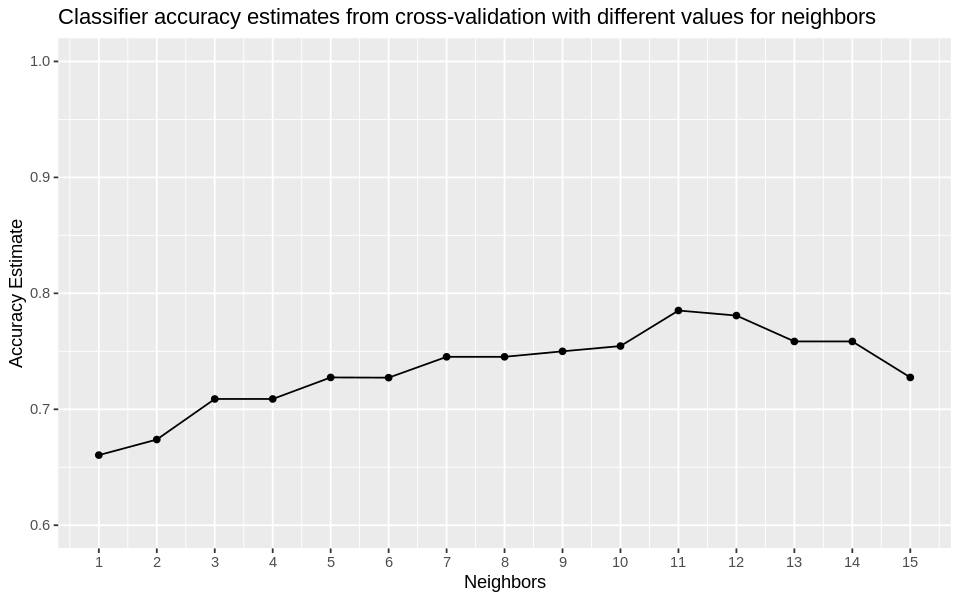

In [26]:
# Find the best k value
set.seed(2130)

gridvals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_k_tuning <- recipe(DEATH_EVENT ~ ejection_fraction + age + anaemia, data = training_data)

#2. Perform 5-fold CV on the training set
knn_vfold_k_tuning <- vfold_cv(training_data, v = 5, strata = DEATH_EVENT)

#3. Create the specs with tune() for number of neighbors
knn_k_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_k_tuning_results <- workflow() |>
    add_recipe(knn_recipe_k_tuning) |>
    add_model(knn_k_tuning) |>
    tune_grid(resamples = knn_vfold_k_tuning, grid = gridvals) |>
    collect_metrics()
                 
accuracies_k_tuning <- knn_k_tuning_results |> 
       filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies_k_tuning, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Classifier accuracy estimates from cross-validation with different values for neighbors") +
       scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.6, 1.0)) # adjusting the y-axis

cross_val_plot        



In [57]:
# Find the best model and test it against the testing set
set.seed(2130)

best_k <- 11

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_best <- recipe(DEATH_EVENT ~ ejection_fraction + age + anaemia, data = training_data)

knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit <- workflow() |>
    add_recipe(knn_recipe_best) |>
    add_model(knn_spec_best) |>
    fit(data = training_data)

                 
hf_predictions <- predict(knn_best_fit, testing_data) |>
    bind_cols(testing_data)

hf_metrics <- hf_predictions |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat <- hf_predictions |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

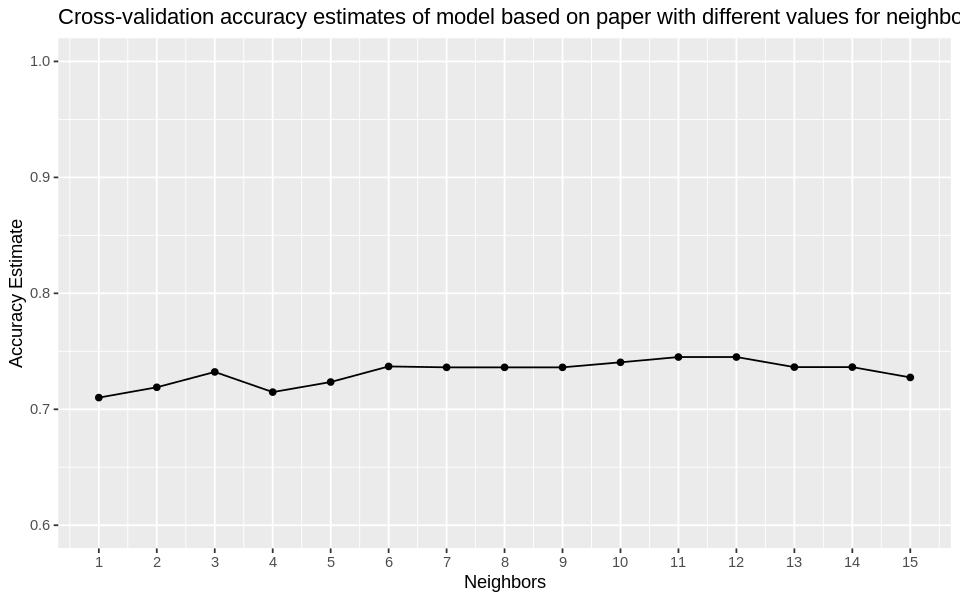

In [40]:
# Find the best k value for the model from paper
set.seed(2130)

gridvals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_k_tuning_paper <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = training_data)

#2. Perform 5-fold CV on the training set
knn_vfold_k_tuning_paper <- vfold_cv(training_data, v = 5, strata = DEATH_EVENT)

#3. Create the specs with tune() for number of neighbors
knn_k_tuning_paper <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_k_tuning_results_paper <- workflow() |>
    add_recipe(knn_recipe_k_tuning_paper) |>
    add_model(knn_k_tuning_paper) |>
    tune_grid(resamples = knn_vfold_k_tuning_paper, grid = gridvals) |>
    collect_metrics()
                 
accuracies_k_tuning_paper <- knn_k_tuning_results_paper |> 
       filter(.metric == "accuracy")

cross_val_plot_paper <- ggplot(accuracies_k_tuning_paper, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Cross-validation accuracy estimates of model based on paper with different values for neighbors") +
       scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.6, 1.0)) # adjusting the y-axis

cross_val_plot_paper        

In [58]:
# Find the best model based on the paper and test it against the testing set
set.seed(2130)

best_k_paper <- 11

#1. Make the recipe (what are the predictors, which is the response variable, what is the data set)
knn_recipe_paper_best <- recipe(DEATH_EVENT ~ ejection_fraction + serum_creatinine, data = training_data)

knn_spec_paper_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_paper) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit_paper <- workflow() |>
    add_recipe(knn_recipe_paper_best) |>
    add_model(knn_spec_paper_best) |>
    fit(data = training_data)

                 
hf_predictions_paper <- predict(knn_best_fit_paper, testing_data) |>
    bind_cols(testing_data)

hf_metrics_paper <- hf_predictions_paper |>
    metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
    filter(.metric == "accuracy")

hf_conf_mat_paper <- hf_predictions_paper |>
    conf_mat(truth = DEATH_EVENT, estimate = .pred_class)

In [60]:
# Compare our model and the paper model
models <- c("Ours", "Paper's")
model_formula <- c("DEATH_EVENT ~ ejection_fraction + age + anemia", 
                   "DEATH_EVENT ~ ejection_fraction + serum_creatinine")
pred_accu_ours <- hf_metrics |>
    select(.estimate) |>
    pull()

pred_accu_paper <- hf_metrics_paper |>
    select(.estimate) |>
    pull()

prediction_accuracy <- c(pred_accu_ours, pred_accu_paper)

prediction_summary <- tibble(models, model_formula, prediction_accuracy)
colnames(prediction_summary) <- c("Model", "Model Formula", "Prediction accuracy on testing data")
prediction_summary

Model   Model Formula                                     
1 Ours    DEATH_EVENT ~ ejection_fraction + age + anemia    
2 Paper's DEATH_EVENT ~ ejection_fraction + serum_creatinine
  Prediction accuracy on testing data
1 0.7066667                          
2 0.8000000

In [61]:
# Our model's confusion matrix
hf_conf_mat

          Truth
Prediction  0  1
         0 42 13
         1  9 11

In [62]:
# Paper model's confusion matrix
hf_conf_mat_paper

          Truth
Prediction  0  1
         0 46 10
         1  5 14

## Methods

A k-nearest-neighbor classifier will be made to answer the proposed question. Most importantly, the variable time (follow-up period) will be excluded because it is different for each patient, and there were no details regarding the kind of follow-ups, which makes it harder to understand the role of this predictor. We acknowledge that this is a simplification, and that our model only predicts whether a patient will die or not after some finite time, but the amount of time does not matter. For variable selection, best subset selection will be attempted first, but if it ends up being non-feasible due to high volumes of computations, we would use forward selection which is less computationally costly. The selected classifier will then be trained with the best K-value found from cross-validation. 

During the process of building our model, visualising the result of each step would be crucial for analysing the result. We can achieve that by generating different charts using the ggplot function. For example, when choosing a k-value with the highest accuracy, we would apply cross-validation, and visualize the result (k-value verses accuracy) by geom_line() function.


## Expected Outcomes and Significance


#### Expected Outcomes:

From our summaries and past studies' findings, we expect our model to use not only serum creatinine and ejection fraction as predictors (Table 1, Fig. 1~8, Chicco & Jurman, 2020), but also the categorical variables that describe a patient’s gender, and statuses regarding anaemia, high blood pressure, and smoking because either the differences between their summary statistics (survived vs dead patients) for those variables are relatively greater or that past studies have found correlation between them and patient death (Table 2, Chairat et al., 2022, Ding et al., 2022, Romiti et al., 2022).


#### Significance:

The model could identify potential factors that correlate with heart failure mortality. From that, we could advocate for better living habits if lifestyle-related factors such as smoking is a major predictor for death of heart failure patients. In the case of biological factors such as serum creatinine levels being correlated with heart failure mortality, researchers could look into potential drug treatments that regulate their levels in patients’ bodies to prolong their lifespans. 

#### Future Directions:

The model for this project is merely predicting whether a heart failure patient will die or not based on some health information and the time factor is ignored for simplification. For future projects, a more impactful model we could work on is one that can predict the patient’s probability of survival after some specific amount of time given their current health information.
 

## References:

1. Ahmad, T., Munir, A., Bhatti, S. H., Aftab, M., & Raza, M. A. (2017). Survival analysis of heart failure patients: A case study. *PloS One, 12*(7), e0181001-e0181001. https://doi.org/10.1371/journal.pone.0181001

2. Chairat, K., Rattanavipanon, W., Tanyasaensook, K., Chindavijak, B., Chulavatnatol, S., & Nathisuwan, S. (2020). Relationship of anemia and clinical outcome in heart failure patients with preserved versus reduced ejection fraction in a rural area of Thailand. *International Journal of Cardiology. Heart & Vasculature*, 30, 100597-100597. https://doi.org/10.1016/j.ijcha.2020.100597.

3. Chicco, D., & Jurman, G. (2020). Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. *BMC Medical Informatics and Decision Making, 20*(1), 16-16. https://doi.org/10.1186/s12911-020-1023-5

4. Ding, N., Shah, A. M., Blaha, M. J., Chang, P. P., Rosamond, W. D., & Matsushita, K. (2022). Cigarette smoking, cessation, and risk of heart failure with preserved and reduced ejection fraction. *Journal of the American College of Cardiology, 79*(23), 2298-2305. https://doi.org/10.1016/j.jacc.2022.03.377

5. Inamdar, A. A., & Inamdar, A. C. (2016). Heart Failure: Diagnosis, Management and Utilization. *Journal of Clinical Medicine, 5*(7), 62. https://doi.org/10.3390/jcm5070062

6. Romiti, G. F., Recchia, F., Zito, A., Visioli, G., Basili, S., & Raparelli, V. (2022, April 21). Sex and gender-related issues in heart failure. *Cardiology Clinics, 40*(2), 259-268. https://doi.org/10.1016/j.ccl.2021.12.013